In [1]:
!wget -c https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz -O - | tar -xz

--2023-06-11 13:16:21--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-06-11 13:16:23--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘STDOUT’

-                   100%[===================>] 755.23M  13.7MB/s    in 58s     

2023-06-11 13:17:21 (13.0 MB/s) - written to stdout [791918971/791918971]



In [2]:
!wget -c https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz -O - | tar -xz

--2023-06-11 13:17:21--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz [following]
--2023-06-11 13:17:22--  https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/octet-stream]
Saving to: ‘STDOUT’

-                   100%[===================>]  18.28M  6.50MB/s    in 2.8s    

2023-06-11 13:17:26 (6.50 MB/s) - written to stdout [19173078/19173078]



In [3]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (180, 180)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


In [4]:
from IPython.display import Image, display
from tensorflow.keras.utils import load_img
from PIL import ImageOps, Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from PIL import Image
import glob
from tqdm import tqdm

In [5]:
from torch.utils.data import Dataset


class PetDataset(Dataset):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        transformtotens = transforms.ToTensor()
        transformtoimg = transforms.ToPILImage()
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) +(3,) + self.img_size, dtype="float32")
        
        
        for j, path in enumerate(batch_input_img_paths):
            img = Image.open(path)
            img = img.resize(img_size)
            if img.size ==(180,180):
              
              img = transformtotens(img)
              img = torch.reshape(img, (3,180,180))
              x[j] = img
        x=torch.from_numpy(x)
        y = np.zeros((self.batch_size,) + (1,) + self.img_size,  dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = img.resize(img_size)
            if img.size == (180,180):
              y[j] = torch.reshape(torch.from_numpy(np.expand_dims(img, 2)), (1,180,180))
              # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
              y[j] -= 1
        y=torch.from_numpy(y)
        return x, y


In [6]:
import random

val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = PetDataset(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = PetDataset(batch_size, img_size, val_input_img_paths, val_target_img_paths)

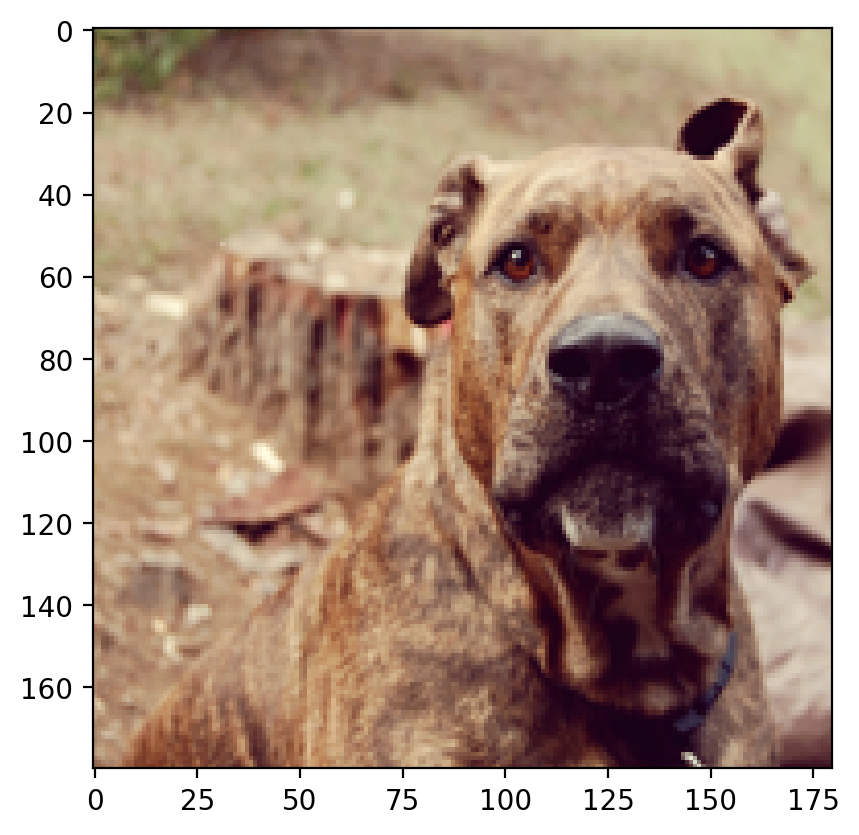

In [8]:
plt.imshow(train_gen[100][0][30].permute(1,2,0))

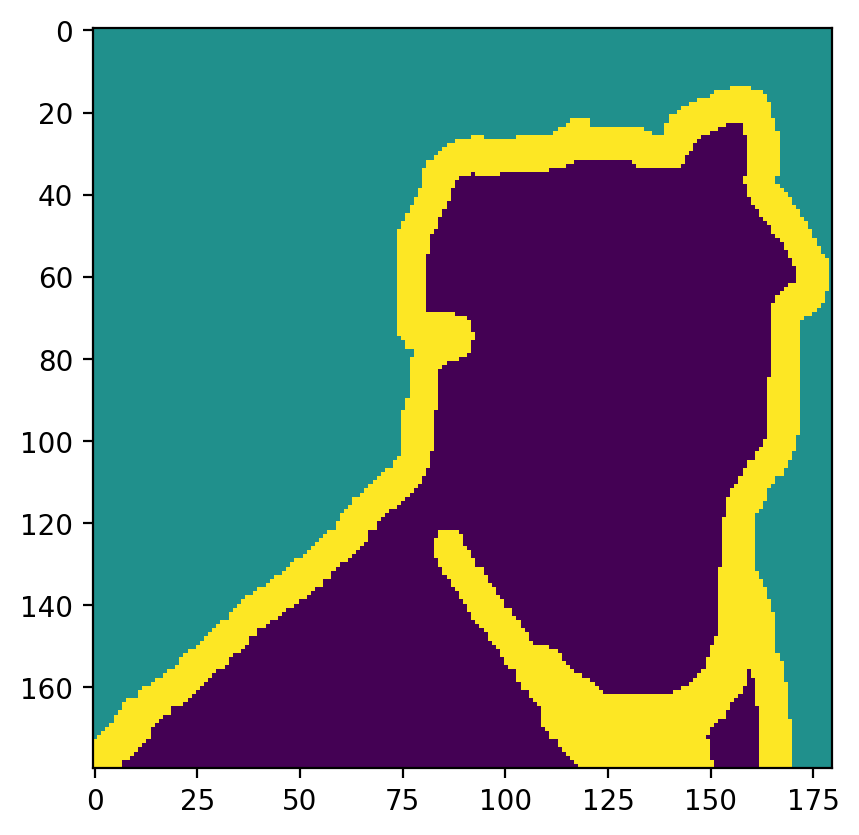

In [7]:
plt.imshow(train_gen[100][1][30].permute(1,2,0))

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch,3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch,3)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

In [11]:
class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

In [12]:
import torchvision
class Decoder(nn.Module):
    def __init__(self, chs=(256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        abc, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [13]:
class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256), dec_chs=(256, 128, 64), num_class=1, retain_dim=False, out_sz=(180,180)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        out = F.interpolate(out, (180,180))
        return out

In [14]:
unet = UNet()

unet(train_gen[0][0]).shape

torch.Size([32, 1, 180, 180])

In [18]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=0.005)

In [19]:
lossvals=[]

In [20]:
for i, (images, labels) in enumerate(train_gen):
  optimizer.zero_grad()
  output = unet(images)
  loss = criterion(output, labels.float())
  loss.backward()
  optimizer.step()
  print("loss", loss)
  lossvals.append(loss)

loss tensor(0.6998, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(2.2695, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6917, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6778, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(16.2602, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.5034, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6788, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6853, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.6859, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


RuntimeError: ignored

In [ ]:
criterion(unet(train_gen[0][0]).type(torch.FloatTensor),train_gen[0][1].type(torch.FloatTensor))

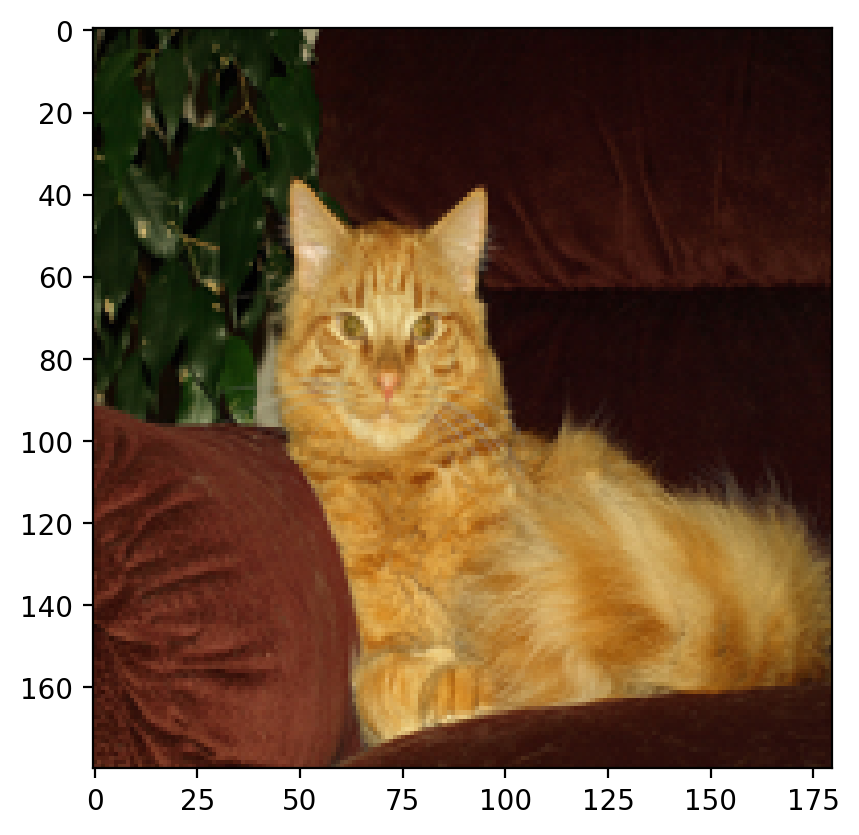

In [23]:
plt.imshow(train_gen[100][0][31].permute(1,2,0))

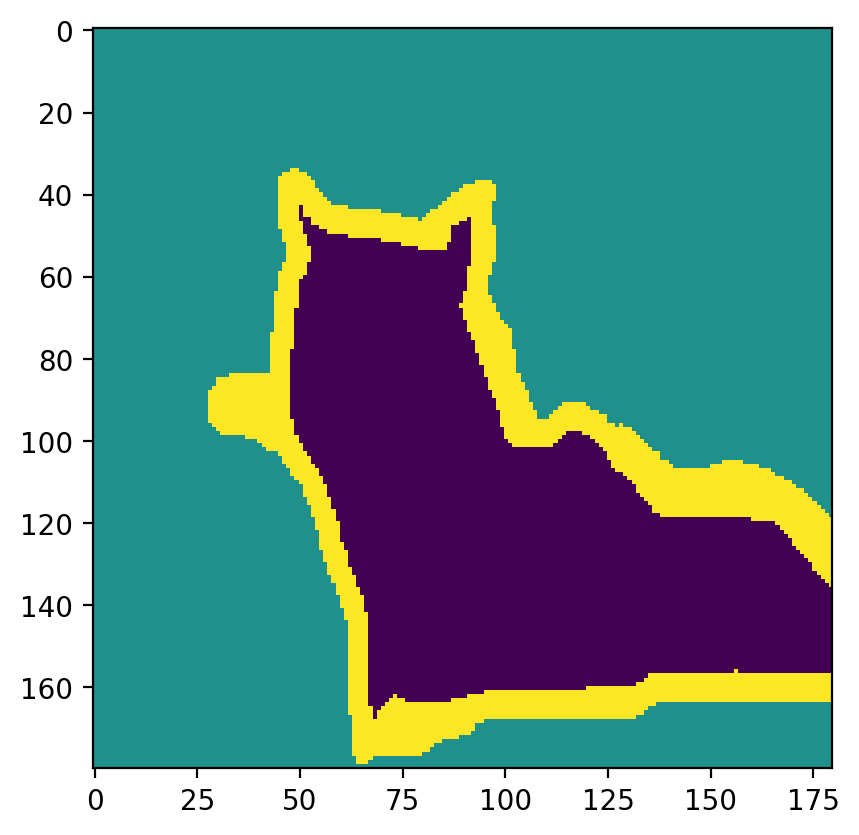

In [24]:
plt.imshow(train_gen[100][1][31].permute(1,2,0))

In [21]:
testing=unet(train_gen[100][0])

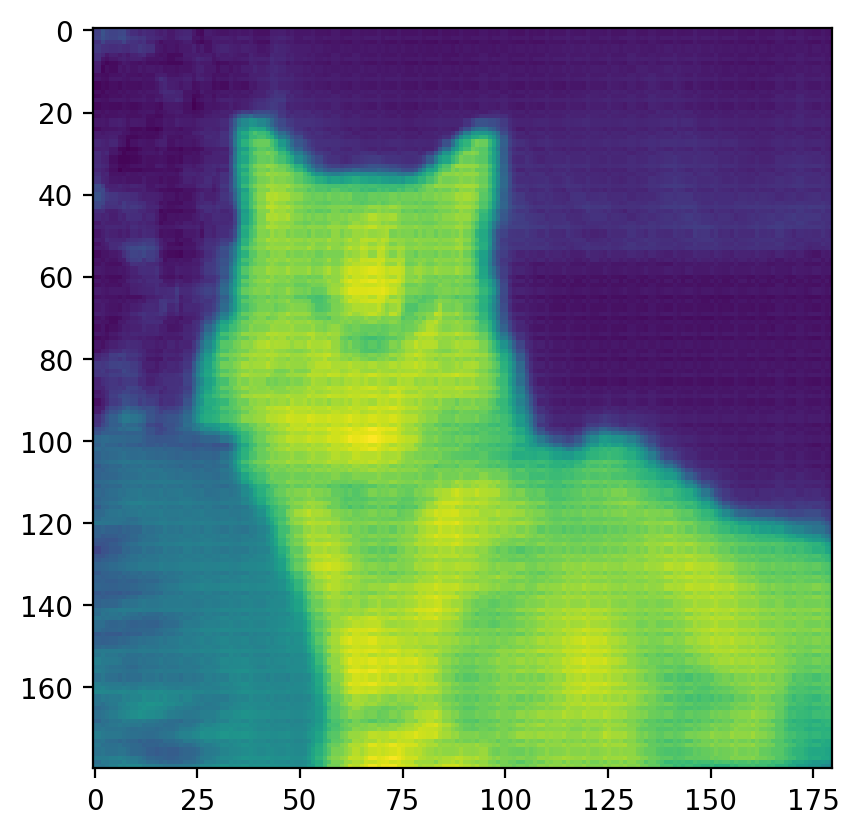

In [22]:
plt.imshow(testing[31].detach().permute(1,2,0))

In [29]:
import matplotlib.pyplot as plt
for x in range(len(lossvals)):
  lossvals[x]=lossvals[x].item()

In [30]:
lossvals

[0.6998295187950134,
 2.2695062160491943,
 0.691663920879364,
 0.6778025031089783,
 16.260183334350586,
 0.5034056901931763,
 0.6787570118904114,
 0.6853022575378418,
 0.6859102249145508]

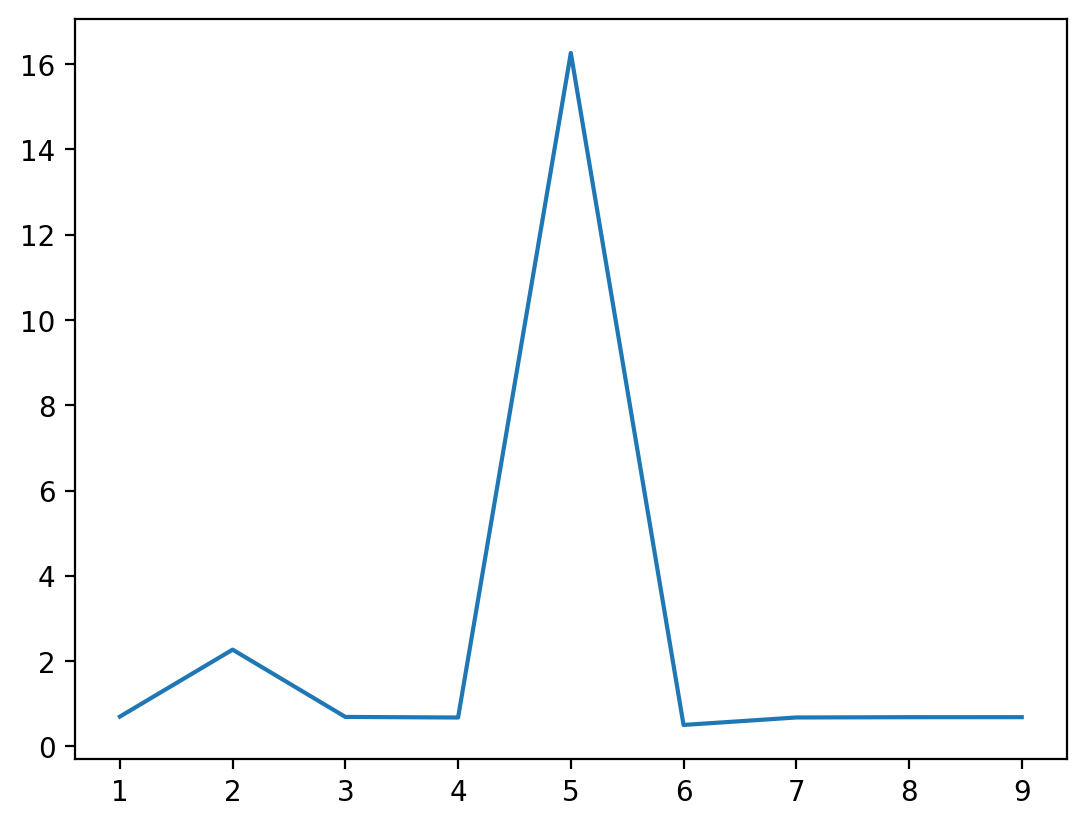

In [35]:
l=[i for i in range(1,10)]
plt.plot(l, lossvals)